In [1]:
!pip install pyspark
!apt-get update
! apt install -y openjdk-11-jre-headless
#! apt install -y openjdk-11-jdk openjdk-8-jre

     -------------------------------------- 281.4/281.4 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 199.0/199.0 KB 12.6 MB/s eta 0:00:00
Using legacy 'setup.py install' for pyspark, since package 'wheel' is not installed.
  Running setup.py install for pyspark: started
  Running setup.py install for pyspark: finished with status 'done'


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [11]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

sc= SparkContext(master= 'local', appName= 'Fake and real news(2)')
ss= SparkSession(sc)

In [12]:
from pyspark.sql.types import StringType, StructField, StructType
def read_data(path):
  schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])
  pd_df= pd.read_csv(path)
  sp_df= ss.createDataFrame(pd_df, schema= schema)
  return sp_df

In [13]:
path_true= '/kaggle/input/fake-and-real-news-dataset/True.csv'
path_fake= '/kaggle/input/fake-and-real-news-dataset/Fake.csv'
true_df= read_data(path_true)
fake_df= read_data(path_fake)

In [14]:
true_df.count()

21417

In [15]:
fake_df.count()

23481

In [16]:
from pyspark.sql.functions import lit, rand
data= true_df.withColumn('fake', lit(0)).union(fake_df.withColumn('fake', lit(1))).orderBy(rand())

In [17]:
data.groupBy('fake').count().show()

+----+-----+
|fake|count|
+----+-----+
|   1|23481|
|   0|21417|
+----+-----+



In [18]:
data.select('subject').distinct().show()

+---------------+
|        subject|
+---------------+
|        US_News|
|      left-news|
|      worldnews|
|       politics|
|   politicsNews|
|Government News|
|    Middle-east|
|           News|
+---------------+



In [19]:
data.show(10)

+--------------------+--------------------+------------+-----------------+----+
|               title|                text|     subject|             date|fake|
+--------------------+--------------------+------------+-----------------+----+
|IT BEGINS…RINO ME...|A longtime Republ...|    politics|        18-Feb-18|   1|
| WATCH: Bernie Sa...|Donald Trump supp...|        News| February 5, 2017|   1|
|WATCH: PRESIDENT ...|WASHINGTON   Pres...|    politics|     Dec 14, 2017|   1|
|WATCH MAXINE WATE...|The latest video ...|   left-news|     May 30, 2017|   1|
| A Fed Up Reporte...|Donald Trump s wa...|        News|    June 27, 2017|   1|
| Woman Gatecrashe...|This should be a ...|        News| February 5, 2016|   1|
|Rohingya row to B...|COX S BAZAR/YANGO...|   worldnews|November 9, 2017 |   0|
|LIFE IN THE MILIT...|Many on the left ...|    politics|      Aug 6, 2017|   1|
|U.S. justices wei...|WASHINGTON (Reute...|politicsNews|  April 19, 2016 |   0|
|GENERAL BOYKIN On...|General Boykin sp.

In [20]:
from pyspark.ml.feature import SQLTransformer, RegexTokenizer, StopWordsRemover, CountVectorizer, Imputer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
StopWordsRemover.loadDefaultStopWords('english')

# 0. Extract tokens from title
title_tokenizer= RegexTokenizer(inputCol= 'title', outputCol= 'title_words',
                                pattern= '\\W', toLowercase= True)
# 1. Remove stop words from title
title_sw_remover= StopWordsRemover(inputCol= 'title_words', outputCol= 'title_sw_removed')
# 2. Compute Term frequency from title
title_count_vectorizer= CountVectorizer(inputCol= 'title_sw_removed', outputCol= 'tf_title')
# 3. Compute Term frequency-inverse document frequency from title
title_tfidf= IDF(inputCol= 'tf_title', outputCol= 'tf_idf_title')
# 4. Extract tokens from text
text_tokenizer= RegexTokenizer(inputCol= 'text', outputCol= 'text_words',
                                pattern= '\\W', toLowercase= True)
# 5. Remove stop words from text
text_sw_remover= StopWordsRemover(inputCol= 'text_words', outputCol= 'text_sw_removed')
# 6. Compute Term frequency from text
text_count_vectorizer= CountVectorizer(inputCol= 'text_sw_removed', outputCol= 'tf_text')
# 7. Compute Term frequency-inverse document frequency text
text_tfidf= IDF(inputCol= 'tf_text', outputCol= 'tf_idf_text')
# 8. StringIndexer subject
subject_str_indexer= StringIndexer(inputCol= 'subject', outputCol= 'subject_idx')
# 9. VectorAssembler
vec_assembler= VectorAssembler(inputCols=['tf_idf_title', 'tf_idf_text', 'subject_idx'], outputCol= 'features')

In [31]:
from pyspark.ml.classification import LogisticRegression

rf = LogisticRegression(featuresCol= 'features', labelCol= 'fake', predictionCol= 'fake_predict', maxIter=50, regParam=0.3, elasticNetParam=0.1,)

In [32]:
from pyspark.ml import Pipeline
rf_pipe= Pipeline(stages=[title_tokenizer, # 0
                title_sw_remover, # 1
                title_count_vectorizer, # 2
                title_tfidf, # 3
                text_tokenizer, # 4
                text_sw_remover, # 5
                text_count_vectorizer, # 6
                text_tfidf, # 7
                subject_str_indexer, # 8
                vec_assembler, # 9
                rf]) # 10 model

In [33]:
train, test= data.randomSplit([0.8, 0.2])

In [34]:
rf_model= rf_pipe.fit(train)

In [35]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'fake', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'fake_predict', col2= 'fake').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

In [38]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'fake', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'fake_predict', col2= 'fake').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

In [39]:
rf_train_result= rf_model.transform(train)

In [40]:
classification_evaluator(rf_train_result)

+-----------------+-----+-----+
|fake_predict_fake|    0|    1|
+-----------------+-----+-----+
|              1.0|    9|18888|
|              0.0|17147|   62|
+-----------------+-----+-----+

accuracy: 0.9980335678280619
f1: 0.9980337073382111
areaUnderROC: 0.9998090623925358


In [54]:
rf_test_result= rf_model.transform(test)

In [51]:
classification_evaluator(rf_test_result)

+-----------------+----+----+
|fake_predict_fake|   0|   1|
+-----------------+----+----+
|              1.0|   3|4517|
|              0.0|4258|  14|
+-----------------+----+----+

accuracy: 0.998066424021838
f1: 0.9980664953490717
areaUnderROC: 0.9995578452975016


In [41]:
lrModel = rf_model.stages[10]
trainingSummary = lrModel.summary

In [42]:
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.001794195250659...|
|0.0|0.003588390501319261|
|0.0|0.005382585751978892|
|0.0|0.007176781002638522|
+---+--------------------+
only showing top 5 rows

areaUnderROC: 0.9998086271501443


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_train = rf_model.transform(train)

y_true = predictions_train.select(['fake']).collect()
y_pred = predictions_train.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 0.9963972340054622, 'recall': 0.9994754021916531, 'f1-score': 0.997933944420195, 'support': 17156}, '1': {'precision': 0.99952373392602, 'recall': 0.9967282321899736, 'f1-score': 0.9981240256823527, 'support': 18950}, 'accuracy': 0.9980335678280619, 'macro avg': {'precision': 0.9979604839657411, 'recall': 0.9981018171908134, 'f1-score': 0.9980289850512738, 'support': 36106}, 'weighted avg': {'precision': 0.9980381572175202, 'recall': 0.9980335678280619, 'f1-score': 0.998033707338211, 'support': 36106}}


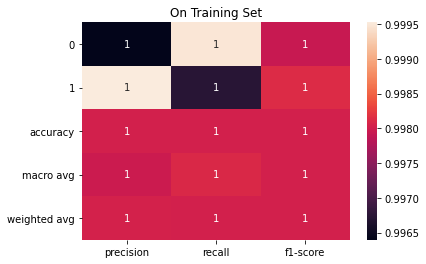

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Training Set')
plt.show()

In [46]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_test = rf_model.transform(test)

y_true = predictions_test.select(['fake']).collect()
y_pred = predictions_test.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 0.9967228464419475, 'recall': 0.9992959399202065, 'f1-score': 0.9980077346771358, 'support': 4261}, '1': {'precision': 0.9993362831858407, 'recall': 0.9969101743544472, 'f1-score': 0.9981217545022649, 'support': 4531}, 'accuracy': 0.998066424021838, 'macro avg': {'precision': 0.9980295648138942, 'recall': 0.9981030571373268, 'f1-score': 0.9980647445897004, 'support': 8792}, 'weighted avg': {'precision': 0.9980696937902847, 'recall': 0.998066424021838, 'f1-score': 0.9980664953490718, 'support': 8792}}


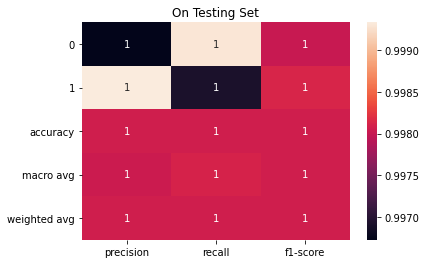

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Testing Set')
plt.show()

In [55]:
class_temp = rf_test_result.select("fake").groupBy("fake")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["fake"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

In [56]:
from sklearn.metrics import confusion_matrix
y_true = rf_test_result.select("fake")
y_true = y_true.toPandas()

y_pred = rf_test_result.select("fake_predict")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[4258,    3],
       [  14, 4517]])

Confusion matrix, without normalization
[[4258    3]
 [  14 4517]]


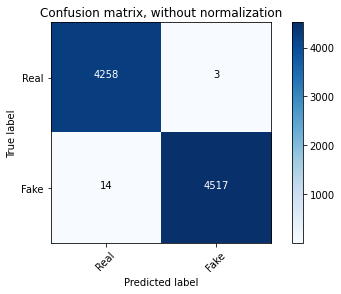

In [57]:
import matplotlib.pyplot as plt
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Real', 'Fake'],
                      title='Confusion matrix, without normalization')
plt.show()